In [1]:
# System imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import hvplot.pandas
import panel as pn
from pathlib import Path
from dotenv import load_dotenv
from panel.interact import interact
from panel import widgets
from string import digits
import csv
import json
import numpy as np
import dateparser
import panel as pn

pn.extension()

%matplotlib inline

In [2]:
# Local imports
import sys
sys.path.append("../libs")

from Constants import Constants
from ProcessingTools import DateProcessingTools

In [3]:
# Construct the tools
debug_level = 0
constants = Constants()
tool_data_processing = DateProcessingTools(debug_level)


In [4]:
# Import all preprocessed data
atlas           = pd.read_pickle(constants.PREPROCESSED_ATLAS_FILE_PATH)
forecast        = pd.read_pickle(constants.PREPROCESSED_FORECAST_DATA_FILE_PATH)
revenue2020     = pd.read_pickle(constants.PREPROCESSED_REVENUE2020_FILE_PATH)
revenue2020A    = pd.read_pickle(constants.PREPROCESSED_REVENUE2020A_FILE_PATH)
atlas2          = pd.read_pickle(constants.PREPROCESSED_ATLAS_2_FILE_PATH)


In [5]:
atlas.head()

Number of Users              Invoice Date  Invoice #  Year  \
Customers                                                                  
University 1           7050.0 2015-03-20 00:00:00-04:00  ATLAS 315  2015   
University 2            250.0 2015-05-28 00:00:00-04:00      AJ501  2015   
University 3            100.0 2015-06-23 00:00:00-04:00      AJ502  2015   
University 4            500.0 2015-06-26 00:00:00-04:00      AJ503  2015   
University 5             15.0 2015-10-07 00:00:00-04:00      AJ504  2015   

                Month  Invoice Amount Subscription 2021 Prediction  \
Customers                                                            
University 1    March         72000.0       1 Year             NaN   
University 2      May          3500.0       1 Year             NaN   
University 3     June          3500.0       1 Year             NaN   
University 4     June          6500.0       1 Year             NaN   
University 5  October           750.0       1 Year             NaN   

             Customers Status            Account Code   \
Customers                                                
University 1             Lost  4700-0-00-00000-18-0000   
University 2           Active  4700-0-00-00000-16-0000   
University 3           Active  4700-0-00-00000-17-0000   
University 4             Lost  4700-0-00-00000-32-0000   
University 5             Lost  4700-0-00-00000-20-0000   

                                                Address State        Lat  \
Customers                                                                  
University 1    1201 N 3rd St #6, Baton Rouge, LA 70802    LA  30.460190   
University 2           1 Kellogg Cir, Emporia, KS 66801    KS  38.392609   
University 3    150 University Blvd, Morehead, KY 40351    KY  38.184921   
University 4       44 Pierrepont Ave, Potsdam, NY 13676    NY  44.663780   
University 5  47645 College Dr, St Marys City, MD 20686    MD  38.190601   

                   Long             Service Start               Service End  \
Customers                                                                     
University 1 -91.188530 2015-03-18 00:00:00-04:00 2016-06-30 00:00:00-04:00   
University 2 -96.181396 2015-06-01 00:00:00-04:00 2016-06-30 00:00:00-04:00   
University 3 -83.434441 2015-06-10 00:00:00-04:00 2016-06-30 00:00:00-04:00   
University 4 -74.978409 2015-06-01 00:00:00-04:00 2016-06-30 00:00:00-04:00   
University 5 -76.426300 2015-10-05 00:00:00-04:00 2016-09-30 00:00:00-04:00   

             Subscription Duration  
Customers                           
University 1              365 days  
University 2              365 days  
University 3              365 days  
University 4              365 days  
University 5              365 days

In [6]:
(atlas["Invoice Date"] - atlas["Service Start"]).apply(lambda date: date.days)

Customers
University 1       2.0
University 2      -4.0
University 3      13.0
University 4      25.0
University 5       2.0
                  ... 
University 236    -1.0
University 392   -24.0
University 300   -83.0
University 81     99.0
University 393   -23.0
Length: 700, dtype: float64

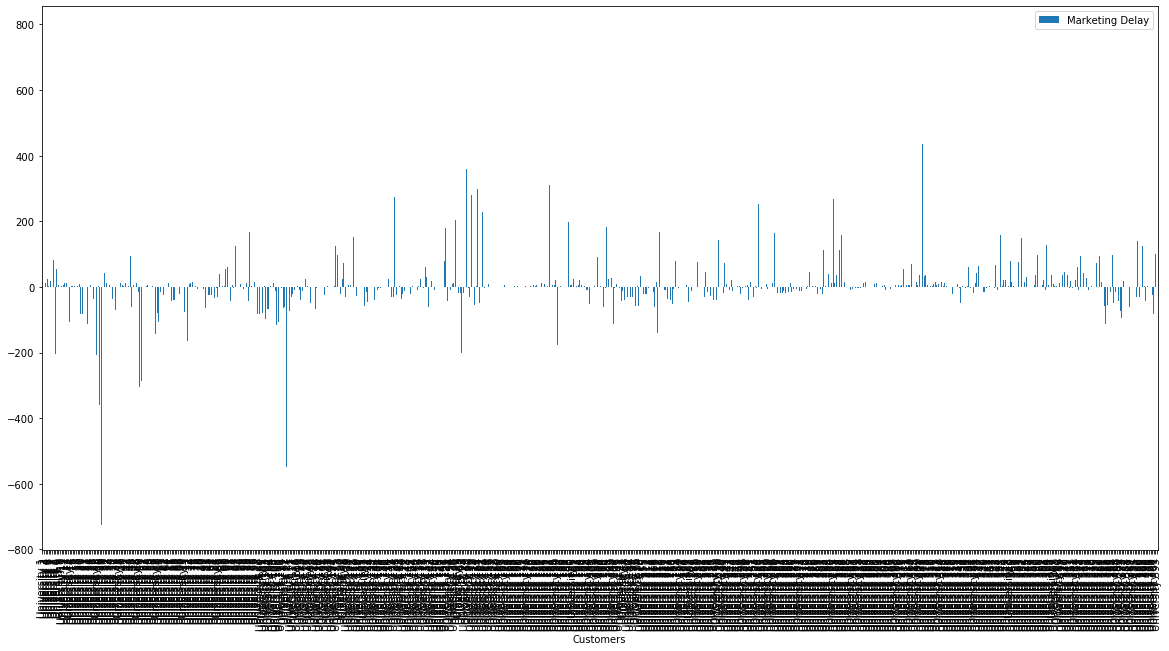

In [7]:
# Plot delays between marketing initiation and payment date (NOTE: This is sample data and not accurate until relevant data is available.)
marketing_delay = atlas["Invoice Date"] - atlas["Service Start"]
marketing_delay_days = marketing_delay.apply(lambda date: date.days)
marketing_delay_df = pd.DataFrame(marketing_delay_days, columns=["Marketing Delay"])
marketing_delay_df.plot.bar(figsize=(20, 10));


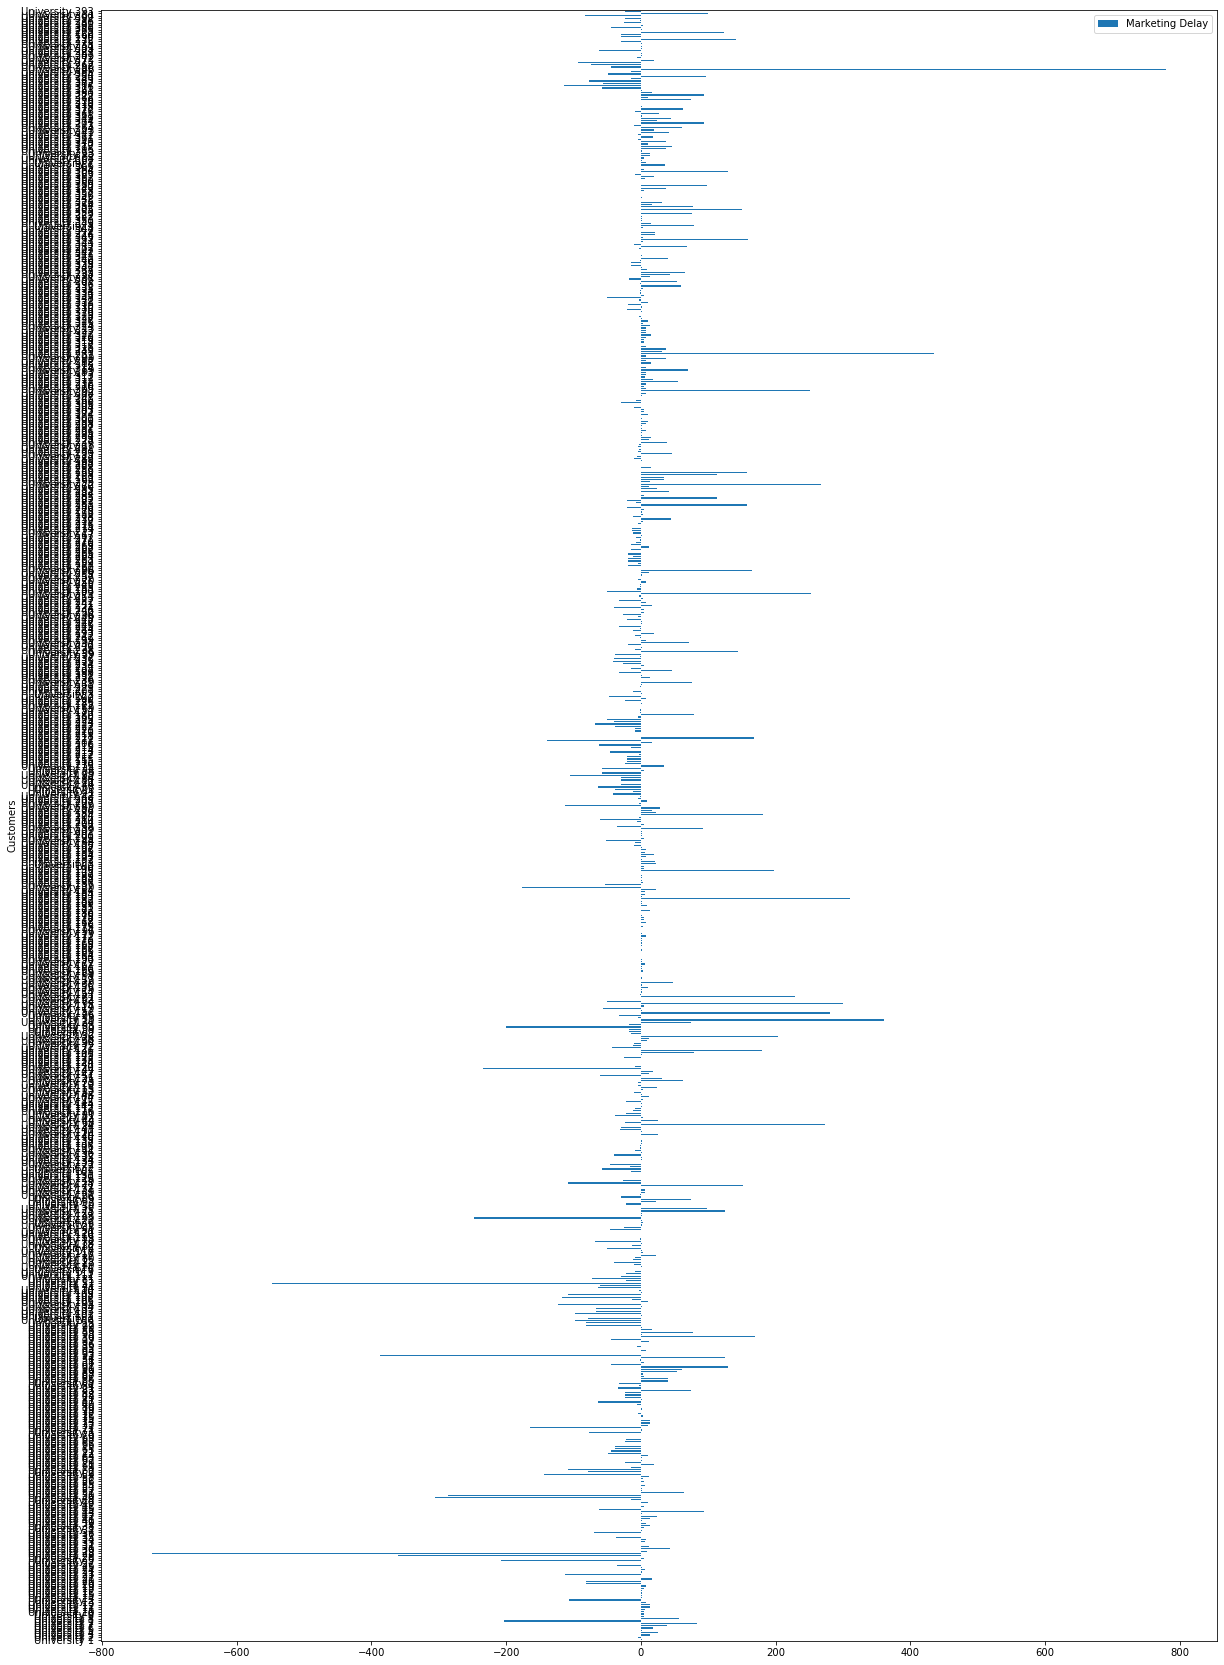

In [8]:
marketing_delay_df.plot.barh(figsize=(20, 30));

In [9]:
# Basic info
total_invoiced_per_customer = atlas.groupby(["Customers"]).sum()
total_invoiced_per_customer.head()

Number of Users  Year  Invoice Amount         Lat        Long
Customers                                                                    
University 1            13600.0  4030        139000.0   60.920165 -182.377131
University 10             350.0  6055         11200.0  119.196630 -270.740841
University 100             25.0  2018          5775.0   39.598072  -77.764449
University 101             50.0  4037          1000.0   84.597386 -142.146872
University 102           1275.0  2018         15750.0   32.502968  -84.939428

In [10]:
atlas.head(1)

Number of Users              Invoice Date  Invoice #  Year  \
Customers                                                                  
University 1           7050.0 2015-03-20 00:00:00-04:00  ATLAS 315  2015   

              Month  Invoice Amount Subscription 2021 Prediction  \
Customers                                                          
University 1  March         72000.0       1 Year             NaN   

             Customers Status            Account Code   \
Customers                                                
University 1             Lost  4700-0-00-00000-18-0000   

                                              Address State       Lat  \
Customers                                                               
University 1  1201 N 3rd St #6, Baton Rouge, LA 70802    LA  30.46019   

                  Long             Service Start               Service End  \
Customers                                                                    
University 1 -91.18853 2015-03-18 00:00:00-04:00 2016-06-30 00:00:00-04:00   

             Subscription Duration  
Customers                           
University 1              365 days

In [11]:
def fcn(df):
    print(f"Size of df: {df.size}")
    customer_subscriptions_ordered_by_date = df.loc[:, ["Subscription", "Service Start"]].sort_values("Service Start")
    print(customer_subscriptions_ordered_by_date)
    print(customer_subscriptions_ordered_by_date)
    return df

# Calculate conversion rates across various subscription combinations
repeat_customers = atlas.index.duplicated()
print(f"There are {repeat_customers.sum()} universities in this dataset who purchased 2 or more subscriptions.")


There are 307 universities in this dataset who purchased 2 or more subscriptions.


In [12]:
# atlas.columns
atlas.loc[:, ["Subscription", "Service Start"]]
atlas.loc[:, ["Subscription", "Service Start"]].sort_values("Service Start")

Subscription             Service Start
Customers                                            
University 1         1 Year 2015-03-18 00:00:00-04:00
University 2         1 Year 2015-06-01 00:00:00-04:00
University 4         1 Year 2015-06-01 00:00:00-04:00
University 3         1 Year 2015-06-10 00:00:00-04:00
University 7         1 Year 2015-09-18 00:00:00-04:00
...                     ...                       ...
University 316     6 Months 2021-02-28 00:00:00-05:00
University 300     6 Months 2021-03-01 00:00:00-05:00
University 66       3 Years                       NaT
University 96        1 Year                       NaT
University 360      30 Days                       NaT

[700 rows x 2 columns]